In [ ]:
pip install torch uvicorn kaleido python-multipart pytorch-forecasting

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.7/59.7 kB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 11.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.7/45.7 kB 3.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.4/140.4 kB 13.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.9/92.9 kB 10.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 48.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 409.6/409.6 kB 27.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 155.8/155.8 kB 14.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.0/67.0 kB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 806.1/806.1 kB 41.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 776.9/776.9 kB 39.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━

In [ ]:
import lightning.pytorch as pl
from lightning.pytorch.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import pandas as pd
import torch

from pytorch_forecasting import Baseline, DeepAR, TimeSeriesDataSet
from pytorch_forecasting.data import NaNLabelEncoder
from pytorch_forecasting.data.examples import generate_ar_data
from pytorch_forecasting.metrics import MAE, SMAPE, MultivariateNormalDistributionLoss, RMSE, QuantileLoss, NormalDistributionLoss

We will load the data now:

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

df_read=pd.read_csv('gdrive/My Drive/Data_CFE/df.csv')

Mounted at /content/gdrive


In [ ]:
print(df_read.iloc[63606]) #max 2987,78 on 4 April 2022 iloc=63606

Date                          2022-04-04
Heure                              08:00
Consommation (MW)                8204.25
Fioul (MW)                        1493.0
Charbon (MW)                       465.5
Gaz (MW)                          8495.5
Nucléaire (MW)                   32110.0
Eolien (MW)                       4408.5
Solaire (MW)                       720.0
Hydraulique (MW)                 16159.5
Bioénergies (MW)                  1019.5
Datetime             2022-04-04 08:00:00
Country                           France
Datetime (Local)     2022-04-04 08:00:00
Price (EUR/MWhe)                 2987.78
Series                                 0
IndexTime                          63606
Name: 63606, dtype: object


In [ ]:
maximum_encoder_length = 192
maximum_prediction_length = 24

df=df_read

In [ ]:
#from sklearn.preprocessing import MinMaxScaler

# Initialize the scaler
#scaler = MinMaxScaler()

# Apply Min-Max scaling to the real-valued columns
#columns_to_scale = ['Price (EUR/MWhe)', 'Consommation (MW)', 'Fioul (MW)', 'Charbon (MW)', 'Gaz (MW)', 'Nucléaire (MW)', 'Eolien (MW)', 'Solaire (MW)', 'Bioénergies (MW)']
#df[columns_to_scale] = scaler.fit_transform(df[columns_to_scale])

In [ ]:
# create dataset and dataloaders
max_encoder_length = maximum_encoder_length
max_prediction_length = maximum_prediction_length

training_cutoff = df["IndexTime"].max() - max_prediction_length

context_length = max_encoder_length
prediction_length = max_prediction_length

training = TimeSeriesDataSet(
    df[lambda x: x.IndexTime <= training_cutoff],
    time_idx="IndexTime",
    target="Price (EUR/MWhe)",
    #categorical_encoders={"series": NaNLabelEncoder().fit(data.series)},
    group_ids=["Series"],
    #static_categoricals=[
    #    "series"
    # ],  # as we plan to forecast correlations, it is important to use series characteristics (e.g. a series identifier)
    static_reals=["Series"],
    time_varying_known_reals=['Consommation (MW)', 'Fioul (MW)', 'Charbon (MW)', 'Gaz (MW)', 'Nucléaire (MW)', 'Eolien (MW)', 'Solaire (MW)', 'Bioénergies (MW)'],
    time_varying_unknown_reals=["Price (EUR/MWhe)"],
    max_encoder_length=context_length,
    max_prediction_length=prediction_length,
)

validation = TimeSeriesDataSet.from_dataset(training, df, min_prediction_idx=training_cutoff + 1)
batch_size = 128 # before 128
# synchronize samples in each batch over time - only necessary for DeepVAR, not for DeepAR
train_dataloader = training.to_dataloader(
    train=True, batch_size=batch_size, num_workers=0 #, batch_sampler="synchronized"
)
val_dataloader = validation.to_dataloader(
    train=False, batch_size=batch_size, num_workers=0 #, batch_sampler="synchronized"
)

In [ ]:
# calculate baseline mean absolute error, i.e. predict next value as the last available value from the history
baseline_predictions = Baseline().predict(val_dataloader, return_y=True)
MAE()(baseline_predictions.output, baseline_predictions.y), SMAPE()(baseline_predictions.output, baseline_predictions.y), RMSE()(baseline_predictions.output, baseline_predictions.y)

/usr/local/lib/python3.10/dist-packages/lightning/pytorch/utilities/parsing.py:198: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/utilities/parsing.py:198: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU av

(tensor(27.0454), tensor(0.1272), tensor(31.2014))

In [ ]:
# Find optimal learning rate:
# configure network and trainer

pl.seed_everything(42)
import pytorch_forecasting as ptf

trainer = pl.Trainer(accelerator="cpu", gradient_clip_val=0.1) #1e-1)
net = DeepAR.from_dataset(
    training,
    learning_rate=0.03, # 3e-2
    hidden_size=16, #30
    rnn_layers=2,
    loss=NormalDistributionLoss(), #MultivariateNormalDistributionLoss(rank=30),
    optimizer="Adam",
)

INFO: Seed set to 42
INFO:lightning.fabric.utilities.seed:Seed set to 42
INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


/usr/local/lib/python3.10/dist-packages/lightning/pytorch/loops/utilities.py:73: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=1` in the `DataLoader` to improve performance.
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=1` in the `DataLoader` to improve performance.


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

INFO: LR finder stopped early after 96 steps due to diverging loss.
INFO:lightning.pytorch.tuner.lr_finder:LR finder stopped early after 96 steps due to diverging loss.
INFO: Learning rate set to 0.057543993733715736
INFO:lightning.pytorch.tuner.lr_finder:Learning rate set to 0.057543993733715736
INFO: Restoring states from the checkpoint path at /content/.lr_find_095c6d16-afae-4e50-9d77-3abc630fcbea.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at /content/.lr_find_095c6d16-afae-4e50-9d77-3abc630fcbea.ckpt
INFO: Restored all states from the checkpoint at /content/.lr_find_095c6d16-afae-4e50-9d77-3abc630fcbea.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restored all states from the checkpoint at /content/.lr_find_095c6d16-afae-4e50-9d77-3abc630fcbea.ckpt


suggested learning rate: 0.057543993733715736


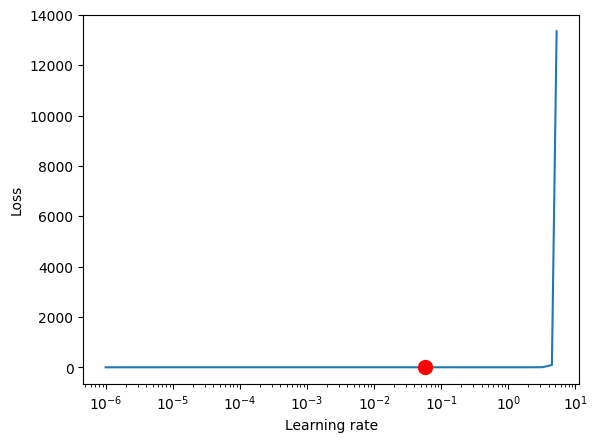

In [ ]:
# find optimal learning rate
from lightning.pytorch.tuner import Tuner

res = Tuner(trainer).lr_find(
    net,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
    min_lr=1e-6, #1e-5,
    max_lr=10.0, #1e0,
    early_stop_threshold=100,
)
print(f"suggested learning rate: {res.suggestion()}")
fig = res.plot(show=True, suggest=True)
fig.show()
net.hparams.learning_rate = res.suggestion()

In [ ]:
# configure network and trainer
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=10, verbose=False, mode="min")
trainer = pl.Trainer(
    max_epochs=10, # before 30
    accelerator="cpu",
    enable_model_summary=True,
    gradient_clip_val=0.1,
    callbacks=[early_stop_callback],
    limit_train_batches=50,
    enable_checkpointing=True,
)

net = DeepAR.from_dataset(
    training,
    learning_rate=0.058, #0.1, #before 1e-2
    log_interval=10,
    log_val_interval=1,
    hidden_size=16, #30
    rnn_layers=2,
    optimizer="Adam",
    loss=NormalDistributionLoss(), #MultivariateNormalDistributionLoss(rank=30),
)


INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [ ]:
# fit network
trainer.fit(
    net,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
)

INFO: 
  | Name                   | Type                   | Params
------------------------------------------------------------------
0 | loss                   | NormalDistributionLoss | 0     
1 | logging_metrics        | ModuleList             | 0     
2 | embeddings             | MultiEmbedding         | 0     
3 | rnn                    | LSTM                   | 4.0 K 
4 | distribution_projector | Linear                 | 34    
------------------------------------------------------------------
4.0 K     Trainable params
0         Non-trainable params
4.0 K     Total params
0.016     Total estimated model params size (MB)
INFO:lightning.pytorch.callbacks.model_summary:
  | Name                   | Type                   | Params
------------------------------------------------------------------
0 | loss                   | NormalDistributionLoss | 0     
1 | logging_metrics        | ModuleList             | 0     
2 | embeddings             | MultiEmbedding         | 0     
3 | 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=10` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


In [ ]:
# Evaluate performance:
# load the best model according to the validation loss
# (given that we use early stopping, this is not necessarily the last epoch)
best_model_path = trainer.checkpoint_callback.best_model_path
best_model = DeepAR.load_from_checkpoint(best_model_path)

In [ ]:
predictions = best_model.predict(val_dataloader, trainer_kwargs=dict(accelerator="cpu"), return_y=True)
MAE()(predictions.output, predictions.y), SMAPE()(predictions.output, predictions.y), RMSE()(predictions.output, predictions.y)

INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


(tensor(14.8544), tensor(0.0712), tensor(19.7760))

In [ ]:
# calculate baseline mean absolute error, i.e. predict next value as the last available value from the history
baseline_predictions = Baseline().predict(val_dataloader, return_y=True)
MAE()(baseline_predictions.output, baseline_predictions.y), SMAPE()(baseline_predictions.output, baseline_predictions.y), RMSE()(baseline_predictions.output, baseline_predictions.y)

INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


(tensor(27.0454), tensor(0.1272), tensor(31.2014))

In [ ]:
raw_predictions = net.predict(
    val_dataloader, mode="raw", return_x=True, trainer_kwargs=dict(accelerator="cpu"), #n_samples=100
)

INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


IndexError: ignored

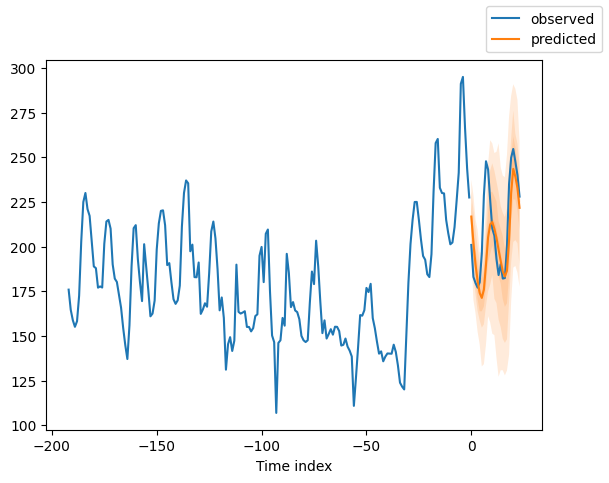

In [ ]:
#Looking at random samples from the validation set is always a good way to understand
#if the forecast is reasonable - and it is!

for idx in range(10):  # plot 10 examples
    best_model.plot_prediction(raw_predictions.x, raw_predictions.output, idx=idx, add_loss_to_title=False)